<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/ClassMismatchDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 26.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import optuna

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np

# Basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Helper to get indices by class
def get_class_indices(dataset, target_classes):
    return [i for i, (_, label) in enumerate(dataset) if label in target_classes]


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [ ]:
# choose 5 classes for labeled set and create two different sets for unlabeled, one with matching 5 classes and another with mismatched 5 classes
# Example class mapping
class_names = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

# Use classes 0–4 for labeled data (airplane to deer)
labeled_classes = [0, 1, 2, 3, 4]
unlabeled_classes_matched = [0, 1, 2, 3, 4]      # matched distribution
unlabeled_classes_mismatched = [5, 6, 7, 8, 9]   # mismatched distribution


In [ ]:
# Labeled set: small subset from classes 0–4
labeled_indices = get_class_indices(full_trainset, labeled_classes)
np.random.shuffle(labeled_indices)
labeled_indices = labeled_indices[:500]  # choose small labeled set
labeled_dataset = Subset(full_trainset, labeled_indices)

# Unlabeled set: two variations
# a) Matched
unlabeled_matched_indices = get_class_indices(full_trainset, unlabeled_classes_matched)
unlabeled_dataset_matched = Subset(full_trainset, unlabeled_matched_indices)

# b) Mismatched
unlabeled_mismatched_indices = get_class_indices(full_trainset, unlabeled_classes_mismatched)
unlabeled_dataset_mismatched = Subset(full_trainset, unlabeled_mismatched_indices)

# Test set: use only classes 0–4 to align with labeled set evaluation
test_indices = get_class_indices(full_testset, labeled_classes)
test_dataset = Subset(full_testset, test_indices)



In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
def plot_class_distribution(labels, title):
    counts = Counter(labels)
    classes = list(range(10))  # CIFAR-10 has 10 classes (0–9)
    values = [counts.get(i, 0) for i in classes]

    plt.figure(figsize=(8, 4))
    plt.bar(classes, values, tick_label=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ])
    plt.title(title)
    plt.ylabel("Number of Samples")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

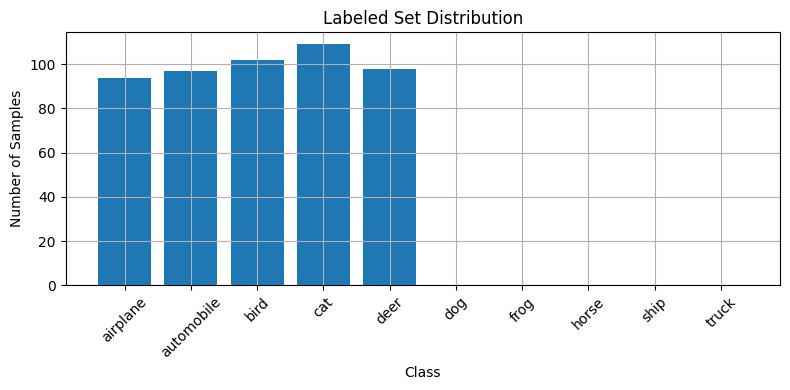

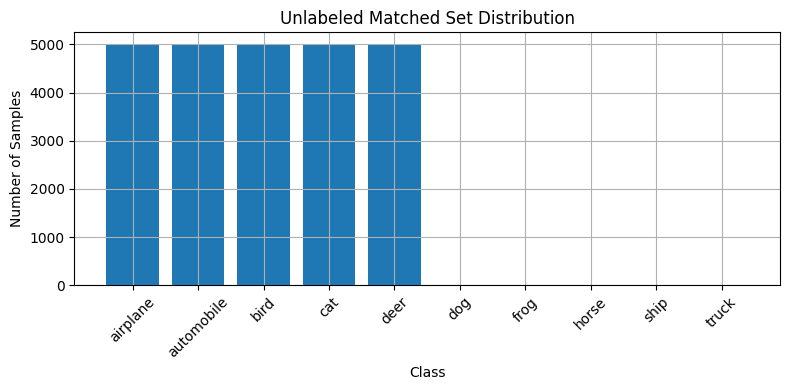

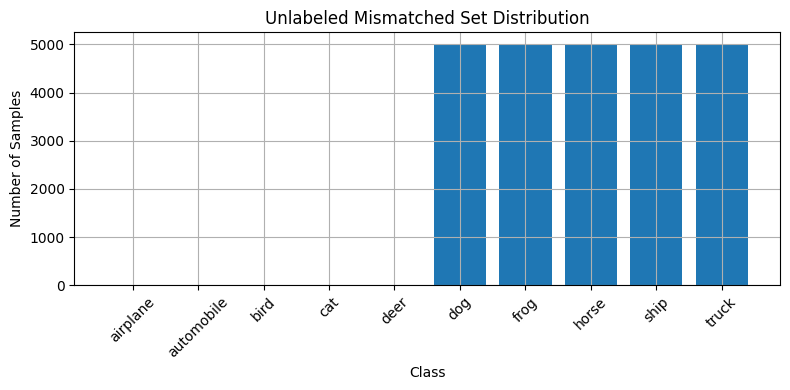

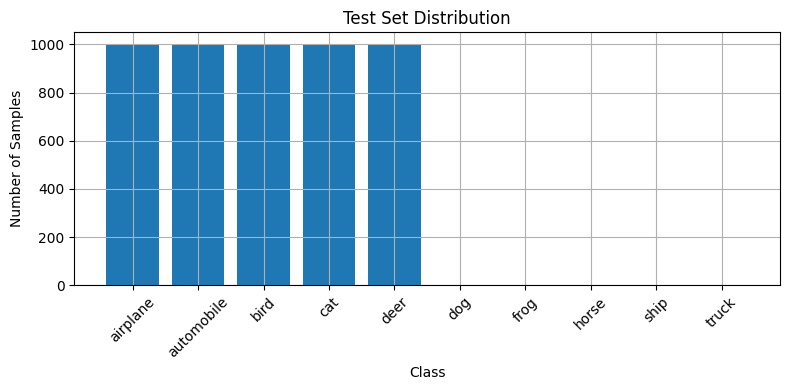

In [ ]:
# Extract labels from Subset
def get_labels_from_subset(subset):
    return [subset.dataset.targets[i] for i in subset.indices]

# labeled_loader, unlabeled_loader, test_loader = get_cifar10_dataloaders()

# Access the underlying Subsets
# labeled_subset = labeled_loader.dataset
# unlabeled_subset = unlabeled_loader.dataset
# test_subset = test_loader.dataset

# Extract and plot labels
labeled_labels = get_labels_from_subset(labeled_dataset)
unlabeled_labels_matched = get_labels_from_subset(unlabeled_dataset_matched)
unlabeled_labels_mismatched = get_labels_from_subset(unlabeled_dataset_mismatched)
test_labels = get_labels_from_subset(test_dataset)
# test_datasubset = test_dataset.dataset
# test_labels = test_datasubset.targets  # Full test set

plot_class_distribution(labeled_labels, "Labeled Set Distribution")
plot_class_distribution(unlabeled_labels_matched, "Unlabeled Matched Set Distribution")
plot_class_distribution(unlabeled_labels_mismatched, "Unlabeled Mismatched Set Distribution")
plot_class_distribution(test_labels, "Test Set Distribution")

In [ ]:
# Get best parameters
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define your VAT model (as in your original code)
class VATModel(nn.Module):
    def __init__(self):
        super(VATModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        return x

# Define VAT loss function
def virtual_adversarial_loss(model, x, epsilon=1e-6):
    x.requires_grad_()
    logits = model(x)

    # Virtual adversarial perturbation
    loss = F.cross_entropy(logits, torch.max(logits, 1)[1])
    loss.backward()
    grad = x.grad

    # Perturbation
    perturbation = epsilon * torch.sign(grad)

    # Perturbed data
    x_perturbed = x + perturbation
    logits_perturbed = model(x_perturbed)
    loss_perturbed = F.cross_entropy(logits_perturbed, torch.max(logits, 1)[1])

    return loss_perturbed

# Combined loss for VAT model
def vat_loss(model, x, labels, criterion, epsilon=1e-6, alpha=1.0):
    # Cross-entropy loss for labeled data
    ce_loss = criterion(model(x), labels)

    # Virtual adversarial loss (VAT)
    va_loss = virtual_adversarial_loss(model, x, epsilon)

    return ce_loss + alpha * va_loss

# Training function for VAT model
def train_vat_model(model, labeled_trainloader, unlabeled_trainloader, criterion, optimizer, num_epochs=10, epsilon=1e-6, alpha=1.0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for (inputs, labels), (inputs_unlabeled, _) in zip(labeled_trainloader, unlabeled_trainloader):
            optimizer.zero_grad()
            # Train on labeled data with VAT applied to unlabeled data
            loss = vat_loss(model, inputs, labels, criterion, epsilon, alpha)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(labeled_trainloader)}")



In [ ]:
# Optuna objective function for hyperparameter search
def optimize_vat_hyperparameters_matched(labeled_trainset, unlabeled_dataset_matched, test_dataset):
    def objective(trial):
        # Suggest hyperparameters
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
        momentum = trial.suggest_uniform('momentum', 0.8, 0.95)
        epsilon = trial.suggest_loguniform('epsilon', 1e-6, 1e-1)
        alpha = trial.suggest_uniform('alpha', 0.5, 2.0)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

        # Create model, optimizer, and criterion
        model = VATModel()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        criterion = nn.CrossEntropyLoss()

        # DataLoader for current batch size
        labeled_trainloader = DataLoader(labeled_trainset, batch_size=batch_size, shuffle=True)
        unlabeled_trainloader = DataLoader(unlabeled_dataset_matched, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Train the VAT model
        train_vat_model(model, labeled_trainloader, unlabeled_trainloader, criterion, optimizer, num_epochs=10, epsilon=epsilon, alpha=alpha)

        # Evaluate the model after training
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy  # Maximize accuracy

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best hyperparameters: {study.best_trial.params}")
    return study.best_trial.params

# Run hyperparameter optimization
vat_best_params_matched = optimize_vat_hyperparameters_matched(labeled_dataset, unlabeled_dataset_matched, test_dataset)


[I 2025-08-31 18:24:45,733] A new study created in memory with name: no-name-03c09443-4489-40b9-8425-e0951a752d0f
/tmp/ipython-input-2690866051.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipython-input-2690866051.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.95)
/tmp/ipython-input-2690866051.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 1e-6, 1e-1)
/tmp/ipython-

Epoch 1, Loss: 5.746415913105011
Epoch 2, Loss: 4.244392931461334
Epoch 3, Loss: 4.0668825507164
Epoch 4, Loss: 4.045694470405579
Epoch 5, Loss: 3.9295566082000732
Epoch 6, Loss: 3.850757896900177
Epoch 7, Loss: 3.8108320236206055
Epoch 8, Loss: 3.7859797179698944
Epoch 9, Loss: 3.7598597705364227
Epoch 10, Loss: 3.7353614270687103


[I 2025-08-31 18:24:55,394] Trial 0 finished with value: 0.0 and parameters: {'lr': 8.892827860693845e-05, 'momentum': 0.8165787415538287, 'epsilon': 0.004807013200551114, 'alpha': 1.7438351456004677, 'batch_size': 64}. Best is trial 0 with value: 0.0.


Epoch 1, Loss: 7.300357758998871
Epoch 2, Loss: 3.092135012149811
Epoch 3, Loss: 2.943705290555954
Epoch 4, Loss: 2.8504227101802826
Epoch 5, Loss: 2.7877358496189117
Epoch 6, Loss: 2.6923046708106995
Epoch 7, Loss: 2.680820971727371
Epoch 8, Loss: 2.4882522523403168
Epoch 9, Loss: 1.996351957321167
Epoch 10, Loss: 1.9411850720643997


[I 2025-08-31 18:25:04,750] Trial 1 finished with value: 45.2 and parameters: {'lr': 0.039392867456184186, 'momentum': 0.8084706917365048, 'epsilon': 0.00010795425704257897, 'alpha': 0.9146661375924272, 'batch_size': 64}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 6.546910375356674
Epoch 2, Loss: 5.759154707193375
Epoch 3, Loss: 3.1373575627803802
Epoch 4, Loss: 3.1854323744773865
Epoch 5, Loss: 3.0762452483177185
Epoch 6, Loss: 2.963134378194809
Epoch 7, Loss: 2.985699623823166
Epoch 8, Loss: 2.975782662630081
Epoch 9, Loss: 2.9547628462314606
Epoch 10, Loss: 2.936725467443466


[I 2025-08-31 18:25:13,581] Trial 2 finished with value: 0.0 and parameters: {'lr': 0.08293698469467087, 'momentum': 0.851611940504395, 'epsilon': 2.4701217040072724e-06, 'alpha': 0.6597357202092249, 'batch_size': 64}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 5.135594487190247
Epoch 2, Loss: 3.589616596698761
Epoch 3, Loss: 3.7653138637542725
Epoch 4, Loss: 3.55094575881958
Epoch 5, Loss: 3.3751757740974426
Epoch 6, Loss: 3.365889847278595
Epoch 7, Loss: 3.283487558364868
Epoch 8, Loss: 3.2540098428726196
Epoch 9, Loss: 3.2287344336509705
Epoch 10, Loss: 3.2080928683280945


[I 2025-08-31 18:25:23,874] Trial 3 finished with value: 0.02 and parameters: {'lr': 0.00523584047140258, 'momentum': 0.8198568736166127, 'epsilon': 0.002211914224356503, 'alpha': 1.5653432178455486, 'batch_size': 128}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 4.740305945277214
Epoch 2, Loss: 3.6801762729883194
Epoch 3, Loss: 3.1386569142341614
Epoch 4, Loss: 3.0267796218395233
Epoch 5, Loss: 2.858112618327141
Epoch 6, Loss: 2.8518353402614594
Epoch 7, Loss: 2.7765904515981674
Epoch 8, Loss: 2.77156138420105
Epoch 9, Loss: 2.75070957839489
Epoch 10, Loss: 2.7288930416107178


[I 2025-08-31 18:25:33,597] Trial 4 finished with value: 20.0 and parameters: {'lr': 0.00021166689291476275, 'momentum': 0.9471256865920739, 'epsilon': 0.00020072368246341397, 'alpha': 1.856304064379692, 'batch_size': 32}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 3.7583901435136795
Epoch 2, Loss: 2.6528163999319077
Epoch 3, Loss: 2.4406590163707733
Epoch 4, Loss: 2.59593802690506
Epoch 5, Loss: 2.3340522572398186
Epoch 6, Loss: 2.301894783973694
Epoch 7, Loss: 2.1738933697342873
Epoch 8, Loss: 2.1318660378456116
Epoch 9, Loss: 2.153790906071663
Epoch 10, Loss: 2.0745812952518463


[I 2025-08-31 18:25:42,894] Trial 5 finished with value: 20.02 and parameters: {'lr': 0.03099871162356269, 'momentum': 0.8824708760452943, 'epsilon': 0.09746689248457423, 'alpha': 0.5500689378621928, 'batch_size': 32}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 6.2355475425720215
Epoch 2, Loss: 6.029686450958252
Epoch 3, Loss: 5.728898525238037
Epoch 4, Loss: 5.408909320831299
Epoch 5, Loss: 5.105503797531128
Epoch 6, Loss: 4.846235275268555
Epoch 7, Loss: 4.633120059967041
Epoch 8, Loss: 4.467477917671204
Epoch 9, Loss: 4.344945073127747
Epoch 10, Loss: 4.255386233329773


[I 2025-08-31 18:25:52,908] Trial 6 finished with value: 0.0 and parameters: {'lr': 1.3502765279278787e-05, 'momentum': 0.8469162868484829, 'epsilon': 0.000430499157472243, 'alpha': 1.942211416942249, 'batch_size': 128}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 4.007726743817329
Epoch 2, Loss: 3.469256415963173
Epoch 3, Loss: 2.9380220770835876
Epoch 4, Loss: 2.941047579050064
Epoch 5, Loss: 2.893244832754135
Epoch 6, Loss: 2.8549222350120544
Epoch 7, Loss: 2.8512698858976364
Epoch 8, Loss: 2.8079775124788284
Epoch 9, Loss: 2.829163581132889
Epoch 10, Loss: 2.7925335615873337


[I 2025-08-31 18:26:03,354] Trial 7 finished with value: 20.0 and parameters: {'lr': 7.417593642242882e-05, 'momentum': 0.8837162786314473, 'epsilon': 1.3747851046433773e-06, 'alpha': 1.5440040347701292, 'batch_size': 32}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 3.5652047842741013
Epoch 2, Loss: 2.7879005819559097
Epoch 3, Loss: 2.6137204989790916
Epoch 4, Loss: 2.5196220874786377
Epoch 5, Loss: 2.4993727803230286
Epoch 6, Loss: 2.433640941977501
Epoch 7, Loss: 2.4266971200704575
Epoch 8, Loss: 2.4189950078725815
Epoch 9, Loss: 2.4034915417432785
Epoch 10, Loss: 2.3976496160030365


[I 2025-08-31 18:26:13,549] Trial 8 finished with value: 20.08 and parameters: {'lr': 0.0012028364728199701, 'momentum': 0.8856548742404474, 'epsilon': 4.214893066172526e-05, 'alpha': 1.3202483418393753, 'batch_size': 32}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 3.881536439061165
Epoch 2, Loss: 2.9477327167987823
Epoch 3, Loss: 2.8450124859809875
Epoch 4, Loss: 2.792622223496437
Epoch 5, Loss: 2.7618418782949448
Epoch 6, Loss: 2.7196883857250214
Epoch 7, Loss: 2.7008015662431717
Epoch 8, Loss: 2.6955473124980927
Epoch 9, Loss: 2.680391013622284
Epoch 10, Loss: 2.6449960619211197


[I 2025-08-31 18:26:22,981] Trial 9 finished with value: 20.0 and parameters: {'lr': 0.0003917084728945756, 'momentum': 0.8251671893951924, 'epsilon': 2.3573801222378487e-06, 'alpha': 1.5306835006607367, 'batch_size': 32}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 3.455629140138626
Epoch 2, Loss: 2.6353745460510254
Epoch 3, Loss: 2.4996513426303864
Epoch 4, Loss: 2.4337198436260223
Epoch 5, Loss: 2.3474223017692566
Epoch 6, Loss: 2.2939636409282684
Epoch 7, Loss: 2.237029016017914
Epoch 8, Loss: 2.225079581141472
Epoch 9, Loss: 2.1453365683555603
Epoch 10, Loss: 2.0737491101026535


[I 2025-08-31 18:26:33,057] Trial 10 finished with value: 25.62 and parameters: {'lr': 0.008884787751878941, 'momentum': 0.9242990820038957, 'epsilon': 2.7296292912770137e-05, 'alpha': 0.9650132591337295, 'batch_size': 64}. Best is trial 1 with value: 45.2.


Epoch 1, Loss: 3.7572313845157623
Epoch 2, Loss: 3.0650834143161774
Epoch 3, Loss: 2.8922678232192993
Epoch 4, Loss: 2.6615352630615234
Epoch 5, Loss: 2.363279938697815
Epoch 6, Loss: 2.1490772664546967
Epoch 7, Loss: 1.9163187891244888
Epoch 8, Loss: 1.7636170834302902
Epoch 9, Loss: 1.6891618371009827
Epoch 10, Loss: 1.6170461177825928


[I 2025-08-31 18:26:42,928] Trial 11 finished with value: 51.32 and parameters: {'lr': 0.01402234428085212, 'momentum': 0.9263142297171456, 'epsilon': 2.6795681104740794e-05, 'alpha': 0.9301744751054642, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 4.055797129869461
Epoch 2, Loss: 2.9141605496406555
Epoch 3, Loss: 2.5962206423282623
Epoch 4, Loss: 2.464973032474518
Epoch 5, Loss: 2.3257614374160767
Epoch 6, Loss: 2.253147214651108
Epoch 7, Loss: 2.226531147956848
Epoch 8, Loss: 2.237404704093933
Epoch 9, Loss: 2.154686838388443
Epoch 10, Loss: 2.1844119280576706


[I 2025-08-31 18:26:52,579] Trial 12 finished with value: 24.88 and parameters: {'lr': 0.009400935196094815, 'momentum': 0.9188760183095172, 'epsilon': 2.030446916186564e-05, 'alpha': 0.9667625699171133, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 13.818040013313293
Epoch 2, Loss: 2.9563622176647186
Epoch 3, Loss: 3.061054915189743
Epoch 4, Loss: 2.6293070316314697
Epoch 5, Loss: 2.5235276222229004
Epoch 6, Loss: 2.593235045671463
Epoch 7, Loss: 2.5761947631835938
Epoch 8, Loss: 2.548957258462906
Epoch 9, Loss: 2.5513589680194855
Epoch 10, Loss: 2.529259353876114


[I 2025-08-31 18:27:01,501] Trial 13 finished with value: 20.0 and parameters: {'lr': 0.09721826071163699, 'momentum': 0.9065312017980335, 'epsilon': 0.00016834415903081525, 'alpha': 0.91745402736536, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 3.860670953989029
Epoch 2, Loss: 3.3149794936180115
Epoch 3, Loss: 3.1531527638435364
Epoch 4, Loss: 3.137250691652298
Epoch 5, Loss: 3.095667690038681
Epoch 6, Loss: 3.0515438318252563
Epoch 7, Loss: 3.02804297208786
Epoch 8, Loss: 3.0032673478126526
Epoch 9, Loss: 2.9846799075603485
Epoch 10, Loss: 2.950044721364975


[I 2025-08-31 18:27:11,670] Trial 14 finished with value: 0.04 and parameters: {'lr': 0.002624850487407937, 'momentum': 0.8028051371367436, 'epsilon': 1.152677589495637e-05, 'alpha': 1.1744274740672251, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 4.771124631166458
Epoch 2, Loss: 2.646206498146057
Epoch 3, Loss: 2.698564499616623
Epoch 4, Loss: 2.4067192524671555
Epoch 5, Loss: 2.2592411637306213
Epoch 6, Loss: 2.2674901485443115
Epoch 7, Loss: 2.1722770035266876
Epoch 8, Loss: 2.1267228722572327
Epoch 9, Loss: 2.0174684673547745
Epoch 10, Loss: 2.063022240996361


[I 2025-08-31 18:27:20,682] Trial 15 finished with value: 29.28 and parameters: {'lr': 0.024423332294690705, 'momentum': 0.8562953819968082, 'epsilon': 0.0012874414077168053, 'alpha': 0.7839939538622713, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 5.10574597120285
Epoch 2, Loss: 3.252073258161545
Epoch 3, Loss: 2.695820778608322
Epoch 4, Loss: 2.472589433193207
Epoch 5, Loss: 2.439771384000778
Epoch 6, Loss: 2.4861997961997986
Epoch 7, Loss: 2.2947848290205
Epoch 8, Loss: 2.3757092654705048
Epoch 9, Loss: 2.102217435836792
Epoch 10, Loss: 1.8734910190105438


[I 2025-08-31 18:27:29,743] Trial 16 finished with value: 42.58 and parameters: {'lr': 0.02645804328523259, 'momentum': 0.949777873890902, 'epsilon': 8.12313273263049e-05, 'alpha': 1.1764258788146287, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 3.999134361743927
Epoch 2, Loss: 3.570305585861206
Epoch 3, Loss: 2.9540740847587585
Epoch 4, Loss: 3.410391330718994
Epoch 5, Loss: 2.8902939558029175
Epoch 6, Loss: 2.946684241294861
Epoch 7, Loss: 3.0200814604759216
Epoch 8, Loss: 2.769712507724762
Epoch 9, Loss: 2.9255350828170776
Epoch 10, Loss: 2.7502288818359375


[I 2025-08-31 18:27:40,267] Trial 17 finished with value: 0.0 and parameters: {'lr': 0.0026343219441450467, 'momentum': 0.89996924800537, 'epsilon': 8.901867663512072e-06, 'alpha': 0.792776241368988, 'batch_size': 128}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 5.031347751617432
Epoch 2, Loss: 3.1014425456523895
Epoch 3, Loss: 2.5692698657512665
Epoch 4, Loss: 2.4600878059864044
Epoch 5, Loss: 2.3899212181568146
Epoch 6, Loss: 2.3284261226654053
Epoch 7, Loss: 2.353777140378952
Epoch 8, Loss: 2.296573668718338
Epoch 9, Loss: 2.253595918416977
Epoch 10, Loss: 2.2409298717975616


[I 2025-08-31 18:27:48,861] Trial 18 finished with value: 20.36 and parameters: {'lr': 0.016507978102849402, 'momentum': 0.8658270420640056, 'epsilon': 0.012451761907393954, 'alpha': 1.0637917418649951, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Epoch 1, Loss: 5.751191943883896
Epoch 2, Loss: 4.629536926746368
Epoch 3, Loss: 3.694872707128525
Epoch 4, Loss: 3.4862941205501556
Epoch 5, Loss: 3.2616510689258575
Epoch 6, Loss: 3.169640839099884
Epoch 7, Loss: 3.149499386548996
Epoch 8, Loss: 3.1239308416843414
Epoch 9, Loss: 2.989276885986328
Epoch 10, Loss: 2.9996210038661957


[I 2025-08-31 18:27:58,036] Trial 19 finished with value: 5.58 and parameters: {'lr': 0.04674424887432321, 'momentum': 0.8356189726894264, 'epsilon': 6.126891328737915e-06, 'alpha': 1.3317637901625643, 'batch_size': 64}. Best is trial 11 with value: 51.32.


Best trial: 51.32
Best hyperparameters: {'lr': 0.01402234428085212, 'momentum': 0.9263142297171456, 'epsilon': 2.6795681104740794e-05, 'alpha': 0.9301744751054642, 'batch_size': 64}


In [ ]:
vat_best_params_matched

{'lr': 0.01402234428085212,
 'momentum': 0.9263142297171456,
 'epsilon': 2.6795681104740794e-05,
 'alpha': 0.9301744751054642,
 'batch_size': 64}

In [ ]:
# Optuna objective function for hyperparameter search
def optimize_vat_hyperparameters_mismatched(labeled_trainset, unlabeled_dataset_mismatched, test_dataset):
    def objective(trial):
        # Suggest hyperparameters
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
        momentum = trial.suggest_uniform('momentum', 0.8, 0.95)
        epsilon = trial.suggest_loguniform('epsilon', 1e-6, 1e-1)
        alpha = trial.suggest_uniform('alpha', 0.5, 2.0)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

        # Create model, optimizer, and criterion
        model = VATModel()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        criterion = nn.CrossEntropyLoss()

        # DataLoader for current batch size
        labeled_trainloader = DataLoader(labeled_trainset, batch_size=batch_size, shuffle=True)
        unlabeled_trainloader = DataLoader(unlabeled_dataset_mismatched, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Train the VAT model
        train_vat_model(model, labeled_trainloader, unlabeled_trainloader, criterion, optimizer, num_epochs=10, epsilon=epsilon, alpha=alpha)

        # Evaluate the model after training
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy  # Maximize accuracy

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best hyperparameters: {study.best_trial.params}")
    return study.best_trial.params

# Run hyperparameter optimization
vat_best_params_mismatched = optimize_vat_hyperparameters_matched(labeled_dataset, unlabeled_dataset_mismatched, test_dataset)

[I 2025-08-31 18:28:12,691] A new study created in memory with name: no-name-c77a8eb6-828f-4a38-98af-4dd7f5d9a7e3
/tmp/ipython-input-2690866051.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipython-input-2690866051.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.8, 0.95)
/tmp/ipython-input-2690866051.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 1e-6, 1e-1)
/tmp/ipython-

Epoch 1, Loss: 5.493642807006836
Epoch 2, Loss: 5.433537125587463
Epoch 3, Loss: 5.312277555465698
Epoch 4, Loss: 5.149728298187256
Epoch 5, Loss: 4.959857225418091
Epoch 6, Loss: 4.772050976753235
Epoch 7, Loss: 4.597423553466797
Epoch 8, Loss: 4.444145083427429
Epoch 9, Loss: 4.311676740646362
Epoch 10, Loss: 4.202258110046387


[I 2025-08-31 18:28:23,199] Trial 0 finished with value: 0.0 and parameters: {'lr': 1.3705168403783135e-05, 'momentum': 0.8476471254577693, 'epsilon': 0.0012334876874666102, 'alpha': 1.4647879171891889, 'batch_size': 128}. Best is trial 0 with value: 0.0.


Epoch 1, Loss: 3.851985141634941
Epoch 2, Loss: 3.1754719018936157
Epoch 3, Loss: 2.798367902636528
Epoch 4, Loss: 2.746817499399185
Epoch 5, Loss: 2.6956291049718857
Epoch 6, Loss: 2.6849756687879562
Epoch 7, Loss: 2.648725464940071
Epoch 8, Loss: 2.648920938372612
Epoch 9, Loss: 2.6147817075252533
Epoch 10, Loss: 2.6250879913568497


[I 2025-08-31 18:28:33,622] Trial 1 finished with value: 20.0 and parameters: {'lr': 0.00010111045333785887, 'momentum': 0.9016866063305384, 'epsilon': 0.03648640410201572, 'alpha': 1.1495837182309134, 'batch_size': 32}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 4.003889292478561
Epoch 2, Loss: 4.169368743896484
Epoch 3, Loss: 3.198624938726425
Epoch 4, Loss: 2.750593602657318
Epoch 5, Loss: 2.8084335327148438
Epoch 6, Loss: 2.917293757200241
Epoch 7, Loss: 2.6764546036720276
Epoch 8, Loss: 2.6653055548667908
Epoch 9, Loss: 2.7407513558864594
Epoch 10, Loss: 2.66597181558609


[I 2025-08-31 18:28:43,768] Trial 2 finished with value: 20.0 and parameters: {'lr': 0.00017097092673133322, 'momentum': 0.9243701626543077, 'epsilon': 1.7010554518769846e-06, 'alpha': 1.367952923602887, 'batch_size': 64}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 4.607411980628967
Epoch 2, Loss: 4.260405778884888
Epoch 3, Loss: 3.7358055114746094
Epoch 4, Loss: 3.600419044494629
Epoch 5, Loss: 3.884118974208832
Epoch 6, Loss: 4.146984815597534
Epoch 7, Loss: 4.188450932502747
Epoch 8, Loss: 4.013549625873566
Epoch 9, Loss: 3.7287949919700623
Epoch 10, Loss: 3.4578835368156433


[I 2025-08-31 18:28:54,328] Trial 3 finished with value: 0.0 and parameters: {'lr': 4.416623872986089e-05, 'momentum': 0.9329900991279612, 'epsilon': 5.213040350195702e-06, 'alpha': 1.093545818463603, 'batch_size': 128}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 3.00186350941658
Epoch 2, Loss: 2.3870635479688644
Epoch 3, Loss: 2.3230597376823425
Epoch 4, Loss: 2.29877470433712
Epoch 5, Loss: 2.2872476875782013
Epoch 6, Loss: 2.28193661570549
Epoch 7, Loss: 2.267742305994034
Epoch 8, Loss: 2.248718060553074
Epoch 9, Loss: 2.2333271503448486
Epoch 10, Loss: 2.218012437224388


[I 2025-08-31 18:29:04,069] Trial 4 finished with value: 20.0 and parameters: {'lr': 0.00040066484553310725, 'momentum': 0.8294093597628389, 'epsilon': 0.0003119261222019215, 'alpha': 0.5486521678315609, 'batch_size': 32}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 3.807639956474304
Epoch 2, Loss: 4.020443558692932
Epoch 3, Loss: 3.7732136249542236
Epoch 4, Loss: 3.0627013444900513
Epoch 5, Loss: 3.047760248184204
Epoch 6, Loss: 3.2574867010116577
Epoch 7, Loss: 3.137821614742279
Epoch 8, Loss: 3.0006203055381775
Epoch 9, Loss: 3.0467692017555237
Epoch 10, Loss: 3.0823458433151245


[I 2025-08-31 18:29:14,552] Trial 5 finished with value: 0.0 and parameters: {'lr': 0.0004162580331822976, 'momentum': 0.8543087497191965, 'epsilon': 0.01739742335141455, 'alpha': 0.8230942509178336, 'batch_size': 128}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 3.326159656047821
Epoch 2, Loss: 3.147253453731537
Epoch 3, Loss: 3.224303901195526
Epoch 4, Loss: 3.3369452357292175
Epoch 5, Loss: 3.2722169756889343
Epoch 6, Loss: 3.12934672832489
Epoch 7, Loss: 3.0188552737236023
Epoch 8, Loss: 2.9673449993133545
Epoch 9, Loss: 2.949071168899536
Epoch 10, Loss: 2.94714093208313


[I 2025-08-31 18:29:25,050] Trial 6 finished with value: 0.0 and parameters: {'lr': 0.00018384245645816657, 'momentum': 0.8028617274894645, 'epsilon': 0.002229725256489214, 'alpha': 0.5268748835067315, 'batch_size': 128}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 3.898896098136902
Epoch 2, Loss: 4.2683804631233215
Epoch 3, Loss: 4.386815369129181
Epoch 4, Loss: 3.1633414030075073
Epoch 5, Loss: 3.0433860421180725
Epoch 6, Loss: 3.1794689893722534
Epoch 7, Loss: 3.553292691707611
Epoch 8, Loss: 3.205708146095276
Epoch 9, Loss: 2.9438449144363403
Epoch 10, Loss: 2.9411949515342712


[I 2025-08-31 18:29:36,093] Trial 7 finished with value: 0.0 and parameters: {'lr': 0.0004465068900558764, 'momentum': 0.9268280350384865, 'epsilon': 0.0006837128684285618, 'alpha': 0.9335761149911888, 'batch_size': 128}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 5.332699120044708
Epoch 2, Loss: 3.7704044580459595
Epoch 3, Loss: 3.4590224027633667
Epoch 4, Loss: 3.4790230691432953
Epoch 5, Loss: 3.3687985837459564
Epoch 6, Loss: 3.263081133365631
Epoch 7, Loss: 3.200358808040619
Epoch 8, Loss: 3.154961735010147
Epoch 9, Loss: 3.119070142507553
Epoch 10, Loss: 3.088642805814743


[I 2025-08-31 18:29:45,941] Trial 8 finished with value: 20.0 and parameters: {'lr': 8.890998632748223e-05, 'momentum': 0.8458513499051187, 'epsilon': 2.1694025985244812e-05, 'alpha': 1.7209681556234195, 'batch_size': 64}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 5.754405736923218
Epoch 2, Loss: 4.271834313869476
Epoch 3, Loss: 4.036636233329773
Epoch 4, Loss: 3.6162967681884766
Epoch 5, Loss: 3.54763662815094
Epoch 6, Loss: 3.5367009043693542
Epoch 7, Loss: 3.3372742533683777
Epoch 8, Loss: 3.4327924251556396
Epoch 9, Loss: 3.260865330696106
Epoch 10, Loss: 3.304039478302002


[I 2025-08-31 18:29:56,222] Trial 9 finished with value: 0.08 and parameters: {'lr': 0.005171207409647101, 'momentum': 0.8889495310636953, 'epsilon': 0.006529348242011882, 'alpha': 1.7088646862922214, 'batch_size': 128}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 7.853763282299042
Epoch 2, Loss: 3.972155660390854
Epoch 3, Loss: 3.110872194170952
Epoch 4, Loss: 2.805177256464958
Epoch 5, Loss: 2.5924108773469925
Epoch 6, Loss: 2.352354198694229
Epoch 7, Loss: 2.217076785862446
Epoch 8, Loss: 2.173571392893791
Epoch 9, Loss: 1.962717555463314
Epoch 10, Loss: 3.860426038503647


[I 2025-08-31 18:30:04,922] Trial 10 finished with value: 20.0 and parameters: {'lr': 0.0246402886654739, 'momentum': 0.8958374864289279, 'epsilon': 0.09650911685182645, 'alpha': 1.8912564858985976, 'batch_size': 32}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 3.9482540488243103
Epoch 2, Loss: 3.0094342827796936
Epoch 3, Loss: 2.8520757853984833
Epoch 4, Loss: 2.6139103174209595
Epoch 5, Loss: 2.5381745994091034
Epoch 6, Loss: 2.50898540019989
Epoch 7, Loss: 2.4617459774017334
Epoch 8, Loss: 2.450265645980835
Epoch 9, Loss: 2.419703960418701
Epoch 10, Loss: 2.4166449308395386


[I 2025-08-31 18:30:14,696] Trial 11 finished with value: 20.0 and parameters: {'lr': 0.002567164576382773, 'momentum': 0.9113922054984689, 'epsilon': 1.4198321405968095e-06, 'alpha': 1.3175959796939396, 'batch_size': 64}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 4.879046618938446
Epoch 2, Loss: 3.55064994096756
Epoch 3, Loss: 3.5694170594215393
Epoch 4, Loss: 3.939855933189392
Epoch 5, Loss: 3.851755529642105
Epoch 6, Loss: 3.4230684638023376
Epoch 7, Loss: 2.9982470870018005
Epoch 8, Loss: 2.8180914223194122
Epoch 9, Loss: 2.7864120602607727
Epoch 10, Loss: 2.778268128633499


[I 2025-08-31 18:30:24,476] Trial 12 finished with value: 20.0 and parameters: {'lr': 2.161213419699698e-05, 'momentum': 0.9480694439023386, 'epsilon': 7.930545294888528e-05, 'alpha': 1.3906956322857018, 'batch_size': 64}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 3.7472409904003143
Epoch 2, Loss: 3.148962765932083
Epoch 3, Loss: 3.0659583061933517
Epoch 4, Loss: 3.0390520840883255
Epoch 5, Loss: 2.972021996974945
Epoch 6, Loss: 2.9306248873472214
Epoch 7, Loss: 2.9053820222616196
Epoch 8, Loss: 2.890015095472336
Epoch 9, Loss: 2.8545657247304916
Epoch 10, Loss: 2.860019311308861


[I 2025-08-31 18:30:34,593] Trial 13 finished with value: 3.04 and parameters: {'lr': 0.001459317813704426, 'momentum': 0.8779826955054384, 'epsilon': 6.650508884816015e-05, 'alpha': 1.0942598742946545, 'batch_size': 32}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 4.888360768556595
Epoch 2, Loss: 4.50588446855545
Epoch 3, Loss: 3.7875175923109055
Epoch 4, Loss: 3.6924269050359726
Epoch 5, Loss: 3.6826961040496826
Epoch 6, Loss: 3.574869394302368
Epoch 7, Loss: 3.551614210009575
Epoch 8, Loss: 3.513180673122406
Epoch 9, Loss: 3.4855875223875046
Epoch 10, Loss: 3.450437054038048


[I 2025-08-31 18:30:44,480] Trial 14 finished with value: 0.0 and parameters: {'lr': 8.573684096751277e-05, 'momentum': 0.9106236765738398, 'epsilon': 0.0685293022866607, 'alpha': 1.5692948983151334, 'batch_size': 32}. Best is trial 1 with value: 20.0.


Epoch 1, Loss: 9.736803501844406
Epoch 2, Loss: 3.5638697743415833
Epoch 3, Loss: 3.4251285195350647
Epoch 4, Loss: 3.373876214027405
Epoch 5, Loss: 3.4841056168079376
Epoch 6, Loss: 3.1806295216083527
Epoch 7, Loss: 2.9010822474956512
Epoch 8, Loss: 2.3957148492336273
Epoch 9, Loss: 2.258450463414192
Epoch 10, Loss: 2.0154346376657486


[I 2025-08-31 18:30:52,576] Trial 15 finished with value: 41.66 and parameters: {'lr': 0.06130398547305881, 'momentum': 0.9072790575497991, 'epsilon': 1.4687915494557179e-06, 'alpha': 1.1393423626619632, 'batch_size': 64}. Best is trial 15 with value: 41.66.


Epoch 1, Loss: 5.7499410808086395
Epoch 2, Loss: 3.1166559904813766
Epoch 3, Loss: 2.323570765554905
Epoch 4, Loss: 2.36486878991127
Epoch 5, Loss: 2.0930741503834724
Epoch 6, Loss: 2.0994897559285164
Epoch 7, Loss: 1.9598323553800583
Epoch 8, Loss: 1.860620528459549
Epoch 9, Loss: 1.8452887535095215
Epoch 10, Loss: 1.7629137188196182


[I 2025-08-31 18:31:01,537] Trial 16 finished with value: 31.4 and parameters: {'lr': 0.08491624216671616, 'momentum': 0.866144996086958, 'epsilon': 1.137758953977253e-05, 'alpha': 0.8063422844293937, 'batch_size': 32}. Best is trial 15 with value: 41.66.


Epoch 1, Loss: 11.666263192892075
Epoch 2, Loss: 3.7992518544197083
Epoch 3, Loss: 2.8694295585155487
Epoch 4, Loss: 2.5060711205005646
Epoch 5, Loss: 2.483799248933792
Epoch 6, Loss: 2.3597642183303833
Epoch 7, Loss: 2.155258536338806
Epoch 8, Loss: 2.1777159571647644
Epoch 9, Loss: 2.2901214361190796
Epoch 10, Loss: 2.21638947725296


[I 2025-08-31 18:31:10,804] Trial 17 finished with value: 23.62 and parameters: {'lr': 0.09628910594990855, 'momentum': 0.869305625085343, 'epsilon': 8.554562729700572e-06, 'alpha': 0.7287813593621224, 'batch_size': 64}. Best is trial 15 with value: 41.66.


Epoch 1, Loss: 5.232665807008743
Epoch 2, Loss: 4.4202395379543304
Epoch 3, Loss: 2.444113254547119
Epoch 4, Loss: 2.3062992691993713
Epoch 5, Loss: 2.2133457958698273
Epoch 6, Loss: 2.0388727635145187
Epoch 7, Loss: 2.054876685142517
Epoch 8, Loss: 2.025450214743614
Epoch 9, Loss: 1.8230341076850891
Epoch 10, Loss: 1.7187332808971405


[I 2025-08-31 18:31:19,890] Trial 18 finished with value: 48.18 and parameters: {'lr': 0.05816712388493016, 'momentum': 0.8703535595797326, 'epsilon': 4.708114853219166e-06, 'alpha': 0.8570422509072565, 'batch_size': 64}. Best is trial 18 with value: 48.18.


Epoch 1, Loss: 4.259310930967331
Epoch 2, Loss: 2.8712572157382965
Epoch 3, Loss: 2.493141621351242
Epoch 4, Loss: 2.393002927303314
Epoch 5, Loss: 2.393273115158081
Epoch 6, Loss: 2.337938964366913
Epoch 7, Loss: 2.296078324317932
Epoch 8, Loss: 2.2520088851451874
Epoch 9, Loss: 2.204897403717041
Epoch 10, Loss: 2.209818795323372


[I 2025-08-31 18:31:28,854] Trial 19 finished with value: 20.08 and parameters: {'lr': 0.014513556261161645, 'momentum': 0.8275163761524664, 'epsilon': 1.188471239549e-06, 'alpha': 0.9973193119829654, 'batch_size': 64}. Best is trial 18 with value: 48.18.


Best trial: 48.18
Best hyperparameters: {'lr': 0.05816712388493016, 'momentum': 0.8703535595797326, 'epsilon': 4.708114853219166e-06, 'alpha': 0.8570422509072565, 'batch_size': 64}


In [ ]:
from torch.utils.data import DataLoader

# Define your VAT model (as in your original code)
class VATModel(nn.Module):
    def __init__(self):
        super(VATModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        return x

# Define VAT loss function
def virtual_adversarial_loss(model, x, epsilon=1e-6):
    x.requires_grad_()
    logits = model(x)

    # Virtual adversarial perturbation
    loss = F.cross_entropy(logits, torch.max(logits, 1)[1])
    loss.backward()
    grad = x.grad

    # Perturbation
    perturbation = epsilon * torch.sign(grad)

    # Perturbed data
    x_perturbed = x + perturbation
    logits_perturbed = model(x_perturbed)
    loss_perturbed = F.cross_entropy(logits_perturbed, torch.max(logits, 1)[1])

    return loss_perturbed

# Combined loss for VAT model
def vat_loss(model, x, labels, criterion, epsilon=1e-6, alpha=1.0):
    # Cross-entropy loss for labeled data
    ce_loss = criterion(model(x), labels)

    # Virtual adversarial loss (VAT)
    va_loss = virtual_adversarial_loss(model, x, epsilon)

    return ce_loss + alpha * va_loss

# Training function for VAT model
def run_vat_experiment(labeled_dataset, unlabeled_dataset, test_dataset, label, vat_best_params):
# def train_vat_model(model, labeled_trainloader, unlabeled_trainloader, criterion, optimizer, num_epochs=10):
    from sklearn.metrics import classification_report
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer'
        # 'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    your_class_names = class_names
    labeled_trainloader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
    unlabeled_trainloader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
    ssl_model = VATModel()
    ssl_model.train()
    # use best parameters from previous experiment since it is the same architecture
    # vat_best_params = {'lr': 0.004683444236568706, 'momentum': 0.8915845187796497, 'epsilon': 7.633183703505233e-05, 'alpha': 1.6675574886555689, 'batch_size': 64}

    optimizer_ssl = optim.SGD(ssl_model.parameters(), lr=vat_best_params['lr'], momentum=vat_best_params['momentum'])

    # Define criterion for VAT model
    criterion_ssl = nn.CrossEntropyLoss()
    num_epochs=10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for (inputs, labels), (inputs_unlabeled, _) in zip(labeled_trainloader, unlabeled_trainloader):
            optimizer_ssl.zero_grad()
            # Train on labeled data with VAT applied to unlabeled data
            loss = vat_loss(ssl_model, inputs, labels, criterion_ssl, alpha=vat_best_params['alpha'], epsilon=vat_best_params['epsilon'])
            loss.backward()
            optimizer_ssl.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(labeled_trainloader)}")

    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # After evaluation
    all_preds = []
    all_labels = []

    # Evaluation
    ssl_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = ssl_model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4, target_names=class_names))

    acc = 100.0 * correct / total
    print(f"[{label}] Test Accuracy: {acc:.2f}%")
    return acc


In [ ]:
# Run VAT with matched unlabeled data
acc_matched = run_vat_experiment(
    labeled_dataset,
    unlabeled_dataset_matched,
    test_dataset,
    label="Matched Unlabeled Classes",
    vat_best_params=vat_best_params_matched
)

# Run VAT with mismatched unlabeled data
acc_mismatched = run_vat_experiment(
    labeled_dataset,
    unlabeled_dataset_mismatched,
    test_dataset,
    label="Mismatched Unlabeled Classes",
    vat_best_params=vat_best_params_mismatched
)


Epoch 1, Loss: 3.8353759050369263
Epoch 2, Loss: 3.10470050573349
Epoch 3, Loss: 2.9270735383033752
Epoch 4, Loss: 2.8006293177604675
Epoch 5, Loss: 2.4501596689224243
Epoch 6, Loss: 2.3104110956192017
Epoch 7, Loss: 2.1186987906694412
Epoch 8, Loss: 1.9780298471450806
Epoch 9, Loss: 1.8892858922481537
Epoch 10, Loss: 1.7705923467874527
              precision    recall  f1-score   support

    airplane     0.4650    0.7970    0.5873      1000
  automobile     0.6729    0.5430    0.6010      1000
        bird     0.0000    0.0000    0.0000      1000
         cat     0.3148    0.7660    0.4463      1000
        deer     0.6591    0.0290    0.0556      1000

    accuracy                         0.4270      5000
   macro avg     0.4224    0.4270    0.3380      5000
weighted avg     0.4224    0.4270    0.3380      5000

[Matched Unlabeled Classes] Test Accuracy: 42.70%
Epoch 1, Loss: 10.088718920946121
Epoch 2, Loss: 3.0476210713386536
Epoch 3, Loss: 3.4382548928260803
Epoch 4, Loss: 2.548

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
